# Happy :)

This notebook contains analyis of a 4 minutes eyes closed recording of my brain acivity (eeg) while listening to jazz and reflecting on happy moments.

- Data was recorded using [Neurosity Crown](https://neurosity.co)
- [MNE](https://mne.tools/stable/index.html) used for preprocessing.
- Fast Fourier Transform is performed on data from selected channels. 
- An average of FFT for channels is then visualized.

Checkout [eeg-notebooks](https://github.com/NeuroTechX/eeg-notebooks/) for more about analyzing neuro data.

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = "C:\\users\\oreog\\lab\\braindump" 
df_eeg_data = pd.read_csv( data_dir + "\\Recording-09-09-21.csv")

# get the required columns
df_eeg_data = df_eeg_data.iloc[:, 1:]
df_eeg_data

,lsl_time_stamp,CP3,C3,F5,PO3,PO4,F6,C4,CP4
0,1.631206e+12,-4135.832661,-148.393231,-21693.84309,3793.850973,-1088.507597,-23391.14515,-421.509195,-4775.472529
1,1.631206e+12,-4141.197080,-175.550600,-21679.22505,3793.046310,-1089.647536,-23391.07809,-420.771587,-4777.014799
2,1.631206e+12,-4147.097940,-162.005443,-21671.37959,3784.798516,-1097.291833,-23401.53871,-428.617049,-4786.603697
3,1.631206e+12,-4138.246649,-89.988123,-21682.04137,3786.474897,-1096.688336,-23398.52122,-438.004782,-4784.524985
4,1.631206e+12,-4141.599411,-92.335056,-21699.14045,3784.731461,-1095.280176,-23397.38129,-429.756988,-4784.659095
...,...,...,...,...,...,...,...,...,...
61435,1.631206e+12,-1047.536850,281.833144,-11084.69940,1382.947125,-1313.209683,-21496.49954,-488.899704,-9995.923583
61436,1.631206e+12,-1045.793414,247.031478,-11061.49829,1384.623506,-1306.638270,-21483.96021,-485.681053,-9990.827386
61437,1.631206e+12,-1042.977094,226.914908,-11042.92399,1385.227003,-1308.314651,-21493.28089,-492.990073,-9993.442540
61438,1.631206e+12,-1042.641818,251.054792,-11063.91228,1385.763445,-1308.314651,-21502.66862,-488.832649,-9995.118921


Preprocessing data


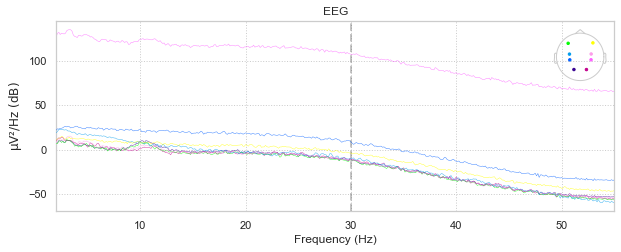

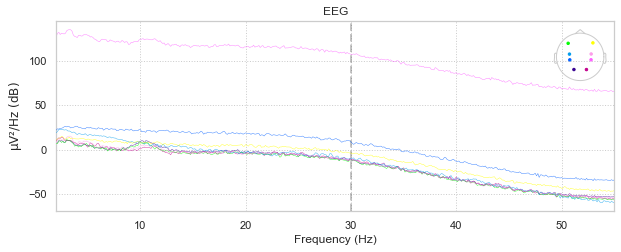

In [7]:
"""Preprocessing with mne
"""
from mne import create_info, concatenate_raws, make_fixed_length_epochs
from mne.io import RawArray
from mne.channels import make_standard_montage

# Define data parameters
ch_names = ['lsl_time_stamp', 'CP3', 'C3', 'F5', 'PO3', 'PO4', 'F6', 'C4', 'CP4']
ch_ind = [1,2,3,4,5,6,7,8]
ch_types =   ['misc'] + ['eeg'] * len(ch_ind) # 8 crown channels
sfreq = 256 # sampling frequency 256Hz

print(f"Preprocessing data")
# Transpose EEG data and convert from uV to Volts
data = df_eeg_data.values[:, ch_ind + [-1]]
data = data.T
data[:-1] *= 1e-6

# create MNE object
info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, verbose=False)
raw = RawArray(data=data, info=info, verbose=False) 
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)

# filter out frequency for noise
raw.filter(l_freq=2, h_freq=30, method="iir")
# for validation 
raw.plot_psd(fmin=2, fmax=55)

In [8]:
### use auto rject
# from autoreject import AutoReject
# mne_epochs = make_fixed_length_epochs(raw, duration=10, preload=True, verbose=True)
# ar = AutoReject()
# epochs_clean = ar.fit_transform(mne_epochs)

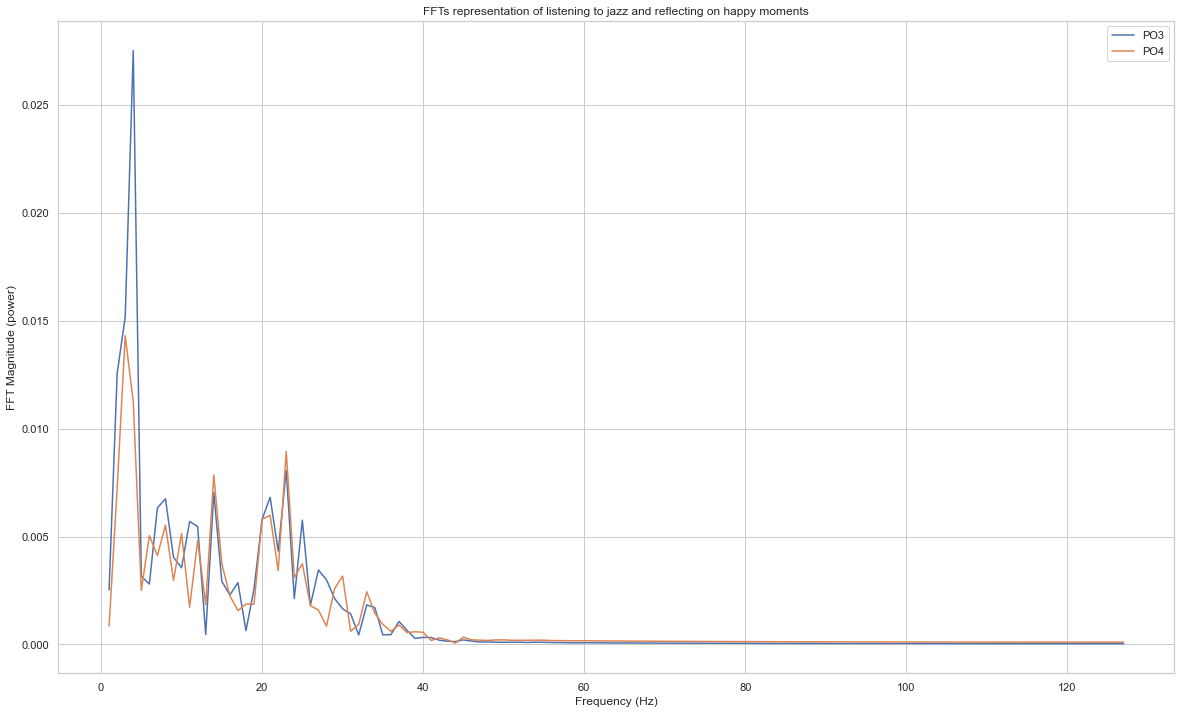

In [9]:
### MNE processing 
"""get & plot fft for reqd. channels
"""

from numpy.fft import fft, fftfreq, ifft

data_rate   = 256 # samples per second
nfft        = 256 # number of samples to put in fourier (1sec of data)
fft_rescale = True


def get_fft_theo_and_freqs(y,data_rate,nfft,fft_rescale=False):
    """
    returns power , frequency
    """
    
    fft_rescale_val = 1.0
    if fft_rescale:
        n_zeros = len(np.where(y==0)[0])
        fft_rescale_val = len(y) / (len(y) - n_zeros)

    sample_spacing = 1.0 / data_rate
    freqs          = fftfreq(nfft, d = sample_spacing)
    freq_mask      = freqs > 0
    
    # FFT and power spectra calculations
    n_samples       = len(y)
    fft_vals        = fft(y, n=nfft)
        
    fft_theo        = np.copy(fft_vals)
    fft_theo        = fft_rescale_val * 2.0 * np.abs( fft_vals / n_samples ) # true theoretical fft
    fft_theo[0]     = fft_theo[0] / 2.0
    
    return fft_theo[freq_mask], freqs[freq_mask]

pre_processed = raw.to_data_frame()
sns.set_theme(style="whitegrid")
plt.figure(figsize = (20,12)) 

# Calculate FFT for channels
# choosing PO3 & PO4 because they represent data from the occipital brain regions

channel_powers = {}
for channel in ['PO3', 'PO4']:
    power, frequency = get_fft_theo_and_freqs( pre_processed[channel], data_rate, nfft, fft_rescale)

    channel_powers[channel] = power
    plt.plot(frequency, power, label=channel)
    plt.xlabel("Frequency (Hz)") 
    plt.ylabel("FFT Magnitude (power)") 
    plt.title("FFTs representation of listening to jazz and reflecting on happy moments") 
    plt.legend()
    


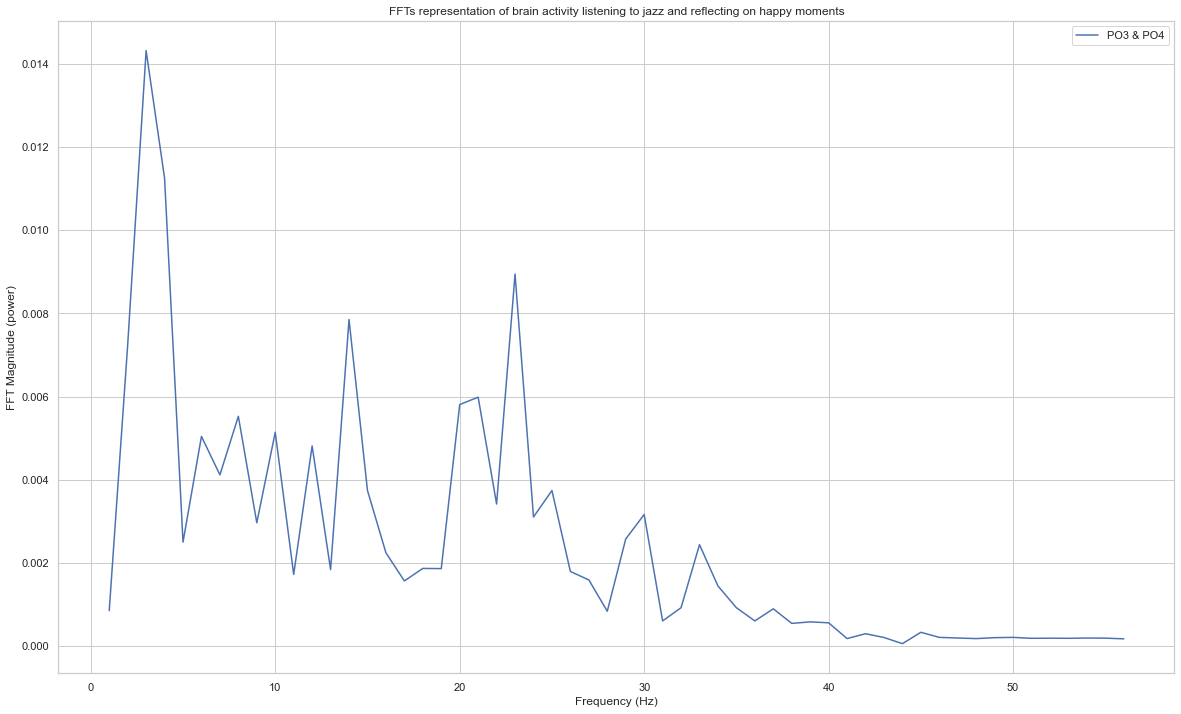

In [10]:
# now let's go ahead and average out both fft
averaged_fft = []
for index in range(len(channel_powers['PO3'])):
    combined_average = (channel_powers['PO3'][index] + channel_powers['PO4'][index]) / 2
    averaged_fft.append(combined_average)

plt.figure(figsize = (20,12)) 
plt.plot(frequency[:56], power[:56], label="PO3 & PO4")
plt.xlabel("Frequency (Hz)") 
plt.ylabel("FFT Magnitude (power)") 
plt.title("FFTs representation of brain activity listening to jazz and reflecting on happy moments") 
plt.legend()